In [ ]:
import pandas as pd
import fasttext
import fasttext.util
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import os
import japanize_matplotlib

In [ ]:
OUTDIR = 'workspace/03-clustering'
os.makedirs(OUTDIR, exist_ok=True)

In [77]:
input_file = 'workspace/02-entity-sentiment/entity-sentiment.csv'

In [78]:
entities_df = pd.read_csv(input_file)

## 類似単語クラスタリング

In [79]:
# FastTextの日本語モデルをダウンロードしてロード
fasttext.util.download_model('ja', if_exists='ignore')  # 'ja'は日本語モデルを指します
model = fasttext.load_model('cc.ja.300.bin')

In [80]:
# グルーピングしたい単語のリスト
words = entities_df["entityName"].to_list()

word_vectors = np.array([model.get_word_vector(word) for word in words])

del model

In [81]:
# DBSCANクラスタリングを適用
# eps: 近傍の半径、min_samples: クラスターを形成するための最小サンプル数
dbscan = DBSCAN(eps=0.4, min_samples=2, metric='cosine')
labels = dbscan.fit_predict(word_vectors)

print("number of clusters: ", len(set(labels)))

# クラスタリング結果をまとめる
cluster_dict = {}
for word, label in zip(words, labels):
    if label not in cluster_dict:
        cluster_dict[label] = []

    if word not in cluster_dict[label]:
        cluster_dict[label].append(word)

clusters = []
for label, words in cluster_dict.items():
    if label == -1:
        clusters.extend([[word] for word in words])
    else:
        clusters.append(words)

del word_vectors
del cluster_dict
del labels



number of clusters:  807


In [82]:
clusters[:10]

[['購入', '梱包', '使用', '発送', '注文', '配送', '利用', '配達', '入手', '発注', '併用', '配達員'],
 ['目'],
 ['病気'],
 ['家電量販店'],
 ['ボタン'],
 ['ところ',
  'こと',
  'もの',
  '場合',
  '動機',
  '事',
  '感じ',
  '物',
  '所',
  'なぁ',
  '模様',
  '仕組み',
  '必要',
  '理由',
  '思い',
  '前提',
  '原因',
  '様子',
  '言葉',
  '意味',
  'モノ',
  '意図',
  'かんじ',
  '方法',
  'きっかけ'],
 ['汗'],
 ['外出', '散歩', '買い物', 'お出かけ', '出掛け', 'でかけ', '出かけ'],
 ['家'],
 ['睡眠']]

## クラスターごとにscoreを合計

In [83]:
results = []
for cluster in clusters:
    total_score = 0
    for entitity_series in entities_df.itertuples():
        if entitity_series.entityName in cluster:
            total_score += entitity_series.score
    
    results.append([cluster, total_score])

results = sorted(results, key=lambda x: x[1], reverse=True)

del clusters
del entities_df

In [84]:
results

[[['風量'], 305.40000009536743],
 [['色', '質感', 'カラー', '手触り', '色合い', '色調', '色目', '風合い'], 105.69999907910824],
 [['ところ',
   'こと',
   'もの',
   '場合',
   '動機',
   '事',
   '感じ',
   '物',
   '所',
   'なぁ',
   '模様',
   '仕組み',
   '必要',
   '理由',
   '思い',
   '前提',
   '原因',
   '様子',
   '言葉',
   '意味',
   'モノ',
   '意図',
   'かんじ',
   '方法',
   'きっかけ'],
  91.59999876469374],
 [['商品', '製品'], 90.89999892562628],
 [['風力'], 67.19999956339598],
 [['風'], 64.90000020712614],
 [['カラビナ',
   'スマホストラップ',
   'ストラップ',
   'ネックストラップ',
   'ストラップつき',
   'カラナビ',
   'ストラップ使い',
   'ストラップ付き',
   'ストラップ付',
   'カラピナ'],
  55.79999968409538],
 [['使い勝手'], 53.39999881386757],
 [['形状', 'デザイン', 'フォルム'], 49.89999930560589],
 [['音'], 43.100000247359276],
 [['購入', '梱包', '使用', '発送', '注文', '配送', '利用', '配達', '入手', '発注', '併用', '配達員'],
  42.8999997228384],
 [['外出', '散歩', '買い物', 'お出かけ', '出掛け', 'でかけ', '出かけ'], 31.69999945908785],
 [['角度'], 30.900000259280205],
 [['夏場', '真冬', '夏', '真夏', '冬場', '冬'], 26.199999652802944],
 [['方', 'ほう'], 24.899999961

## グラフ描写

In [85]:
n_of_bars = 10

In [86]:
def prepare_chart_data(sorted_data):
    labels = [
        ','.join(item[0][:3]) + (' ...' if len(item[0]) > 3 else '')
        for item in sorted_data
    ]
    scores = [item[1] for item in sorted_data]
    return labels, scores

In [87]:
def plot_chart(labels, scores, title, color):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(labels, scores, color=color, alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('単語')
    plt.ylabel('スコア')
    plt.title(title)

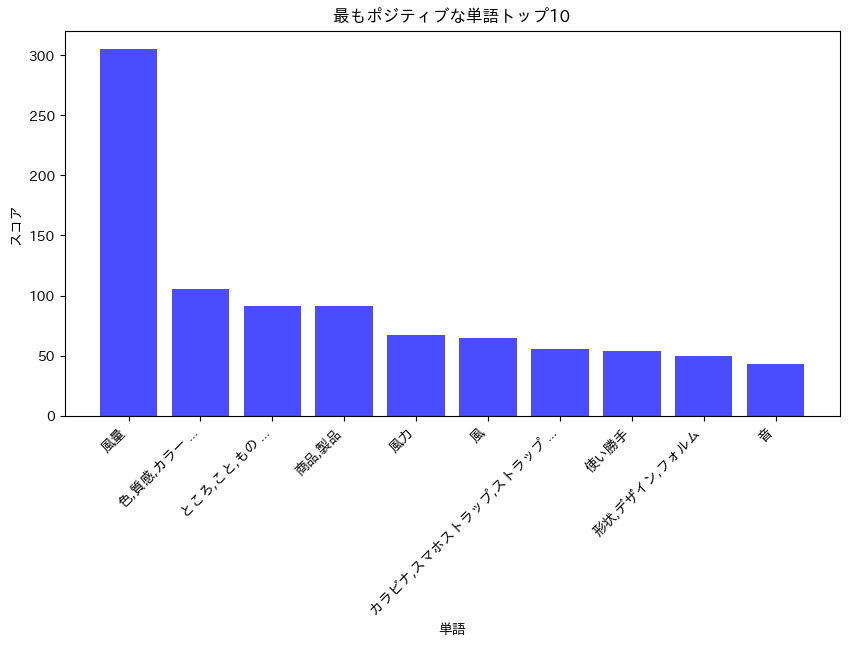

In [88]:
# グラフの描画（ポジティブ）

labels, scores = prepare_chart_data(results[:n_of_bars])

plot_chart(labels, scores, '最もポジティブな単語トップ10', 'blue')

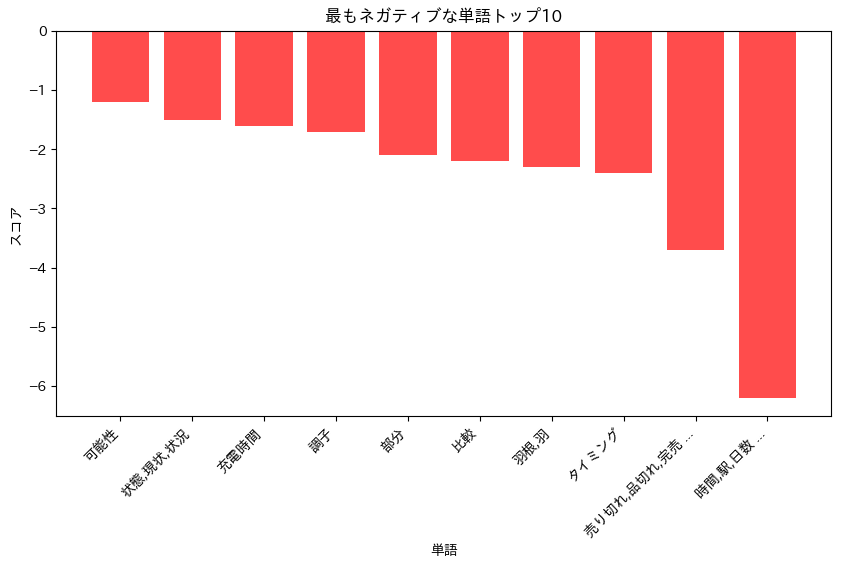

In [89]:
# グラフの描画（ネガティブ）

labels, scores = prepare_chart_data(results[-n_of_bars:])

plot_chart(labels, scores, '最もネガティブな単語トップ10', 'red')

In [ ]:
output = pd.DataFrame([["/".join(cluster), score] for [cluster, score] in results], columns=['cluster','score'])
output.to_csv(f'{OUTDIR}/clustering.csv', index=False)